In [1]:
import pyarrow.parquet as pq
import random
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
RANDOM_SEED = 123

raw = pq.read_table('./Data/not_onehot_cleaned_taxi_data.parquet')
#raw = pq.read_table('./Data/cleaned_taxi_data.parquet')
raw = raw.to_pandas()


feature_cols = list(range(0, 11)) + list(range(12, 17))+ list(range(19, 31))

X = raw.iloc[:, feature_cols]
y = raw.iloc[:, 18].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)


In [30]:
feature_names = X_train.columns

In [4]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state = RANDOM_SEED)
clf.fit(X_train, y_train)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [12]:
ccp_alphas.shape

(2803,)

In [ ]:
clf_dts = [] #created an array that we put decision tree into
i = 0

for ccp_alpha in ccp_alphas :
    clf = DecisionTreeClassifier(random_state = RANDOM_SEED, ccp_alpha = ccp_alpha)
    clf.fit(X_train, y_train)
    clf_dts.append(clf)
    i += 1
    if (i % 100):
        print(i)


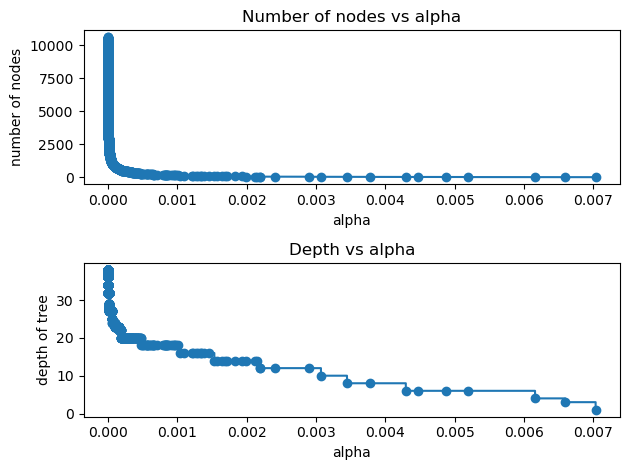

In [15]:
clfs = clf_dts[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

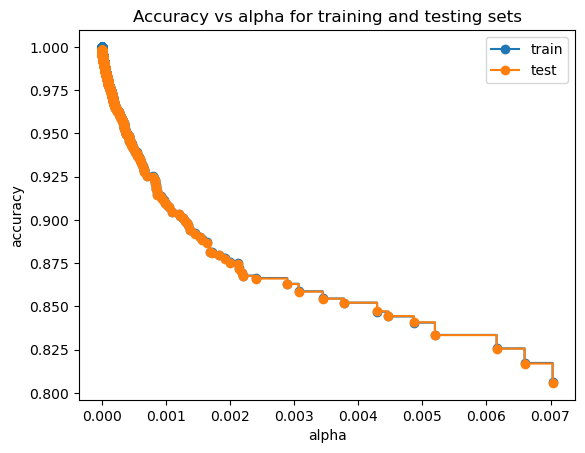

In [16]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [26]:
#pd.Index(test_scores).argmax()
print(f'Test Accuracy: {test_scores[1033]}')
print(f'ccp_alpha: {clfs[1033]}')

out_clf = clfs[1033]

Test Accuracy: 0.9980566352026652
ccp_alpha: DecisionTreeClassifier(ccp_alpha=1.1572588804605477e-06, random_state=123)


In [ ]:
tree.plot_tree(out_clf)

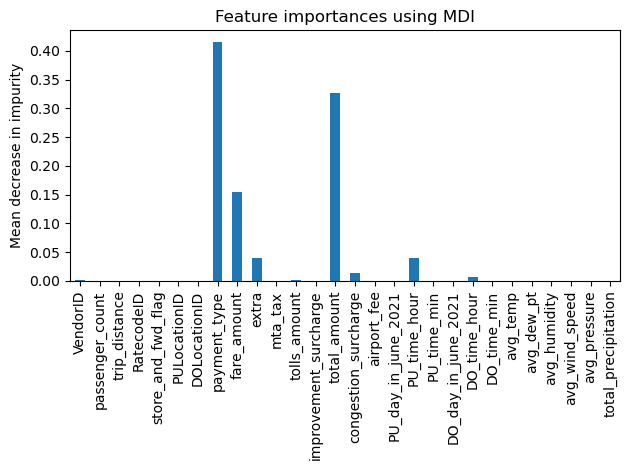

In [33]:
importances = out_clf.feature_importances_

tree_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
tree_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [44]:
## Random Forest
rf_clf = RandomForestClassifier(n_estimators = 500, max_depth=30, random_state=RANDOM_SEED)
rf_clf.fit(X_train, y_train)

rf_y_pred = rf_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, rf_y_pred))


Accuracy: 0.9322686411908996


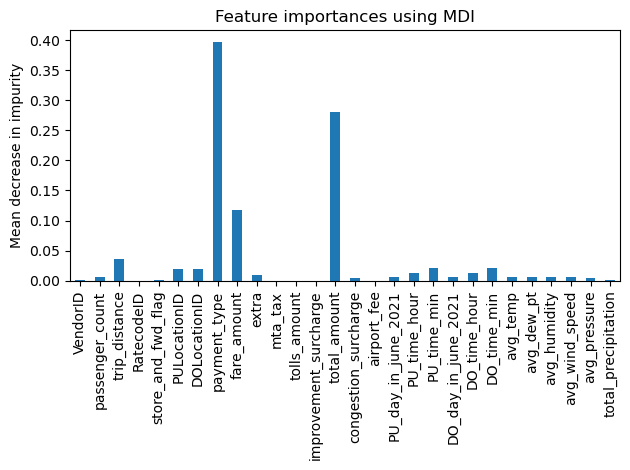

In [45]:
importances = rf_clf.feature_importances_
std = pd.DataFrame([tree.feature_importances_ for tree in rf_clf.estimators_]).std(axis = 0)

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()